In [1]:
import numpy as np 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob as glob
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from scipy import stats
import shutil
import cv2
from cv2 import imread, resize,cvtColor, imwrite
from os.path import exists
from scipy import ndimage
np.random.seed(20)

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization
import autokeras as ak


In [48]:
skin_df=pd.read_csv('D://Visual Studio Python//Project//Skin Cancer Lesion Detection//input//HAM10000_metadata.csv')

<h1  style="color:red ;font-size:30px" > 'nv': 'Melanocytic nevi'
 <br>
'mel': 'Melanoma'
 <br>
'bkl': 'Benign keratosis '
 <br>
'bcc': 'Basal cell carcinoma'
 <br>
'akiec': 'Actinic keratoses'
 <br>
'vasc': 'Vascular lesions'
 <br>
'df': 'Dermatofibroma'
</h1>

In [3]:

skin_df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [4]:
skin_df.describe()

age
count  9958.000000
mean     51.863828
std      16.968614
min       0.000000
25%      40.000000
50%      50.000000
75%      65.000000
max      85.000000

In [5]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [6]:
skin_df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

<h1  style="color:lime ;font-size:40px" > Label Encoding the text values to numeric </h1>

In [7]:
le=LabelEncoder()
le.fit(skin_df['dx'])
print(le.classes_)

['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


In [8]:
skin_df['label']=le.transform(skin_df['dx'])
print(skin_df.sample(10))
skin_df['label'].value_counts()

        lesion_id      image_id   dx    dx_type   age     sex  \
6045  HAM_0001295  ISIC_0024703   nv  follow_up  20.0    male   
9017  HAM_0003033  ISIC_0025989   nv      histo  60.0  female   
4051  HAM_0000479  ISIC_0030441   nv  follow_up  50.0    male   
2523  HAM_0005309  ISIC_0026282  bcc      histo  50.0    male   
6707  HAM_0003303  ISIC_0030980   nv      histo  20.0    male   
9304  HAM_0003035  ISIC_0025168   nv  consensus  10.0  female   
3480  HAM_0005236  ISIC_0026366   nv  follow_up  35.0    male   
8159  HAM_0004830  ISIC_0027567   nv      histo  30.0  female   
120   HAM_0000566  ISIC_0026794  bkl      histo  60.0  female   
8078  HAM_0002533  ISIC_0027755   nv      histo  30.0  female   

         localization  label  
6045  lower extremity      5  
9017  lower extremity      5  
4051             back      5  
2523  upper extremity      1  
6707             back      5  
9304  upper extremity      5  
3480  lower extremity      5  
8159          abdomen      5  
120  

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64

<h1  style="color:DARKOLIVEGREEN ;font-size:40px" > Data Distribution Visualization  </h1>

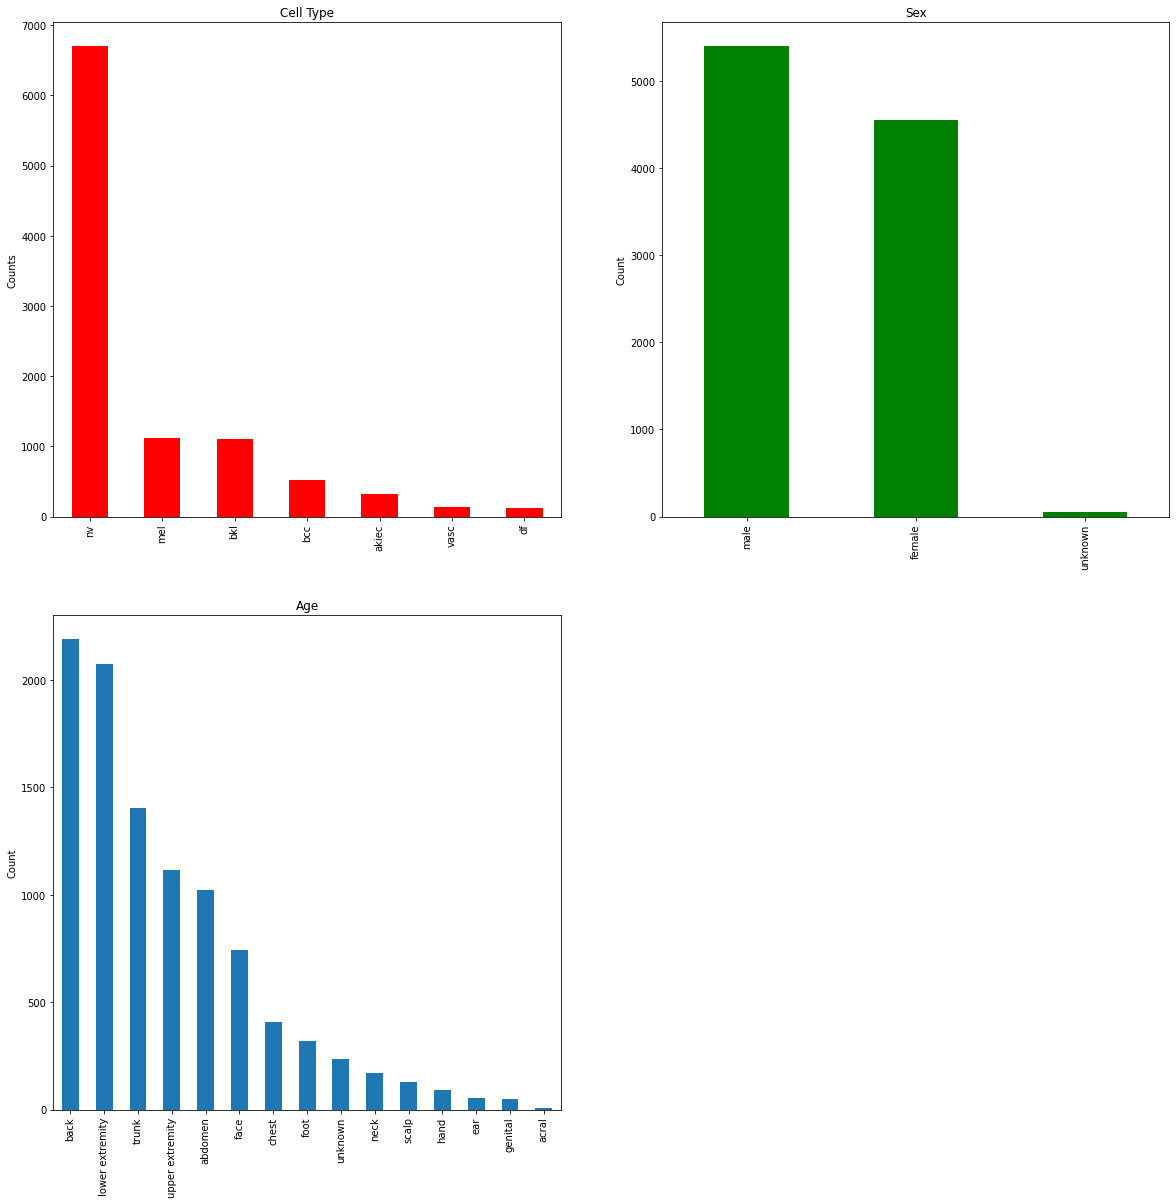

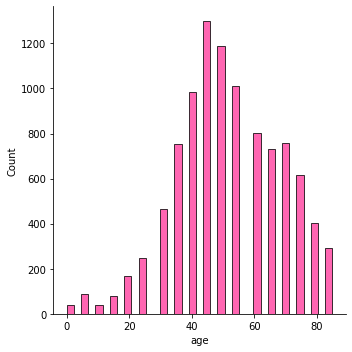

In [9]:
fig=plt.figure(figsize=(20,20))

ax1=fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar',ax=ax1,color='red')
ax1.set_ylabel('Counts')
ax1.set_title('Cell Type')

ax2=fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar',ax=ax2,color='green')
ax2.set_ylabel('Count')
ax2.set_title('Sex')

ax3=fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar',ax=ax3)
ax3.set_ylabel('Count')
ax3.set_title('Localization')
 
sample_age=skin_df[pd.notnull(skin_df['age'])]
sns.displot(sample_age['age'],color='#FF3399')
ax3.set_ylabel('Count')
ax3.set_title('Age')

plt.tight_layout()
plt.show()



<h1  style="color:aqua ;font-size:40px" > Trying to Remove the  hairs from images  </h1>

In [11]:
BASE_PATH = 'D://Visual Studio Python//Project//Skin Cancer Lesion Detection//input//HAM10000_images_part_1//'
hair_images =['ISIC_0024306','ISIC_0024307','ISIC_0024368','ISIC_0024384','ISIC_0024397','ISIC_0024311','ISIC_0024312','ISIC_0024313','ISIC_0024314','ISIC_0024315']

[]

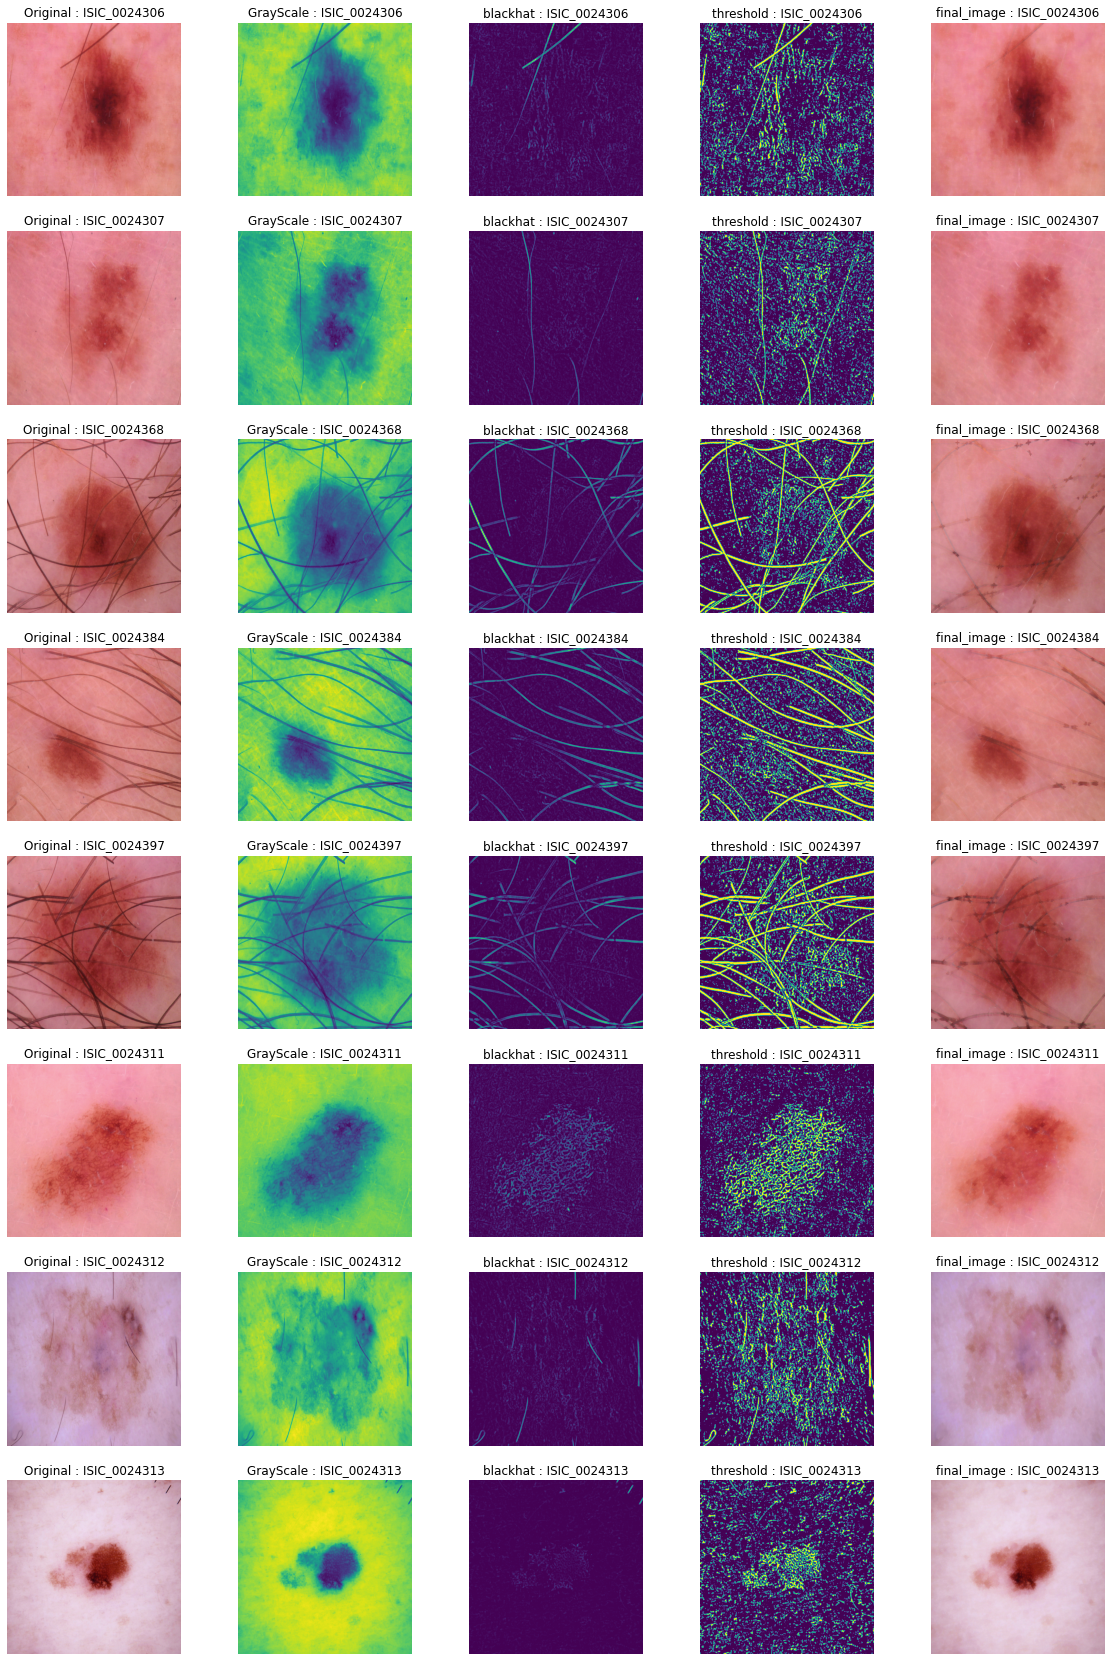

In [12]:
l = len(hair_images[:8])

fig = plt.figure(figsize=(20,30))

for i,image_name in enumerate(hair_images[:8]):
    
    
    image = cv2.imread(BASE_PATH + image_name + '.jpg')
    image_resize = cv2.resize(image,(1024,1024))
    plt.subplot(l, 5, (i*5)+1)
    # Convert the original image to grayscale
    plt.imshow(cv2.cvtColor(image_resize, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original : '+ image_name)
    
    grayScale = cv2.cvtColor(image_resize, cv2.COLOR_RGB2GRAY)
    plt.subplot(l, 5, (i*5)+2)
    plt.imshow(grayScale)
    plt.axis('off')
    plt.title('GrayScale : '+ image_name)
    
    # Kernel for the morphological filtering
    kernel = cv2.getStructuringElement(1,(17,17))
   
    # Perform the blackHat filtering on the grayscale image to find the hair countours
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    plt.subplot(l, 5, (i*5)+3)
    plt.imshow(blackhat)
    plt.axis('off')
    plt.title('blackhat : '+ image_name)
    
    # intensify the hair countours in preparation for the inpainting 
    ret,threshold = cv2.threshold(blackhat,3,255,cv2.THRESH_BINARY)
    

    plt.subplot(l, 5, (i*5)+4)
    plt.imshow(threshold)
    plt.axis('off')
    plt.title('threshold : '+ image_name)
    
    # inpaint the original image depending on the mask
    final_image = cv2.inpaint(image_resize,threshold,1,cv2.INPAINT_TELEA)
    plt.subplot(l, 5, (i*5)+5)
    plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('final_image : '+ image_name)

plt.plot()

In [45]:
'''def hair_removal(image):
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
   
    # Kernel for the morphological filtering
    kernel = cv2.getStructuringElement(1,(17,17))

    # Perform the blackHat filtering on the grayscale image to find the hair countours
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
   
   
    # intensify the hair countours in preparation for the inpainting 
    ret,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
   
    # inpaint the original image depending on the mask
    final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)
    return final_image
#image = cv2.imread('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0030837.jpg')
#plt.imshow(cv2.cvtColor(hair_removal(image), cv2.COLOR_BGR2RGB))'''

"def hair_removal(image):\n    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)\n    \n   \n    # Kernel for the morphological filtering\n    kernel = cv2.getStructuringElement(1,(17,17))\n\n    # Perform the blackHat filtering on the grayscale image to find the hair countours\n    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)\n   \n   \n    # intensify the hair countours in preparation for the inpainting \n    ret,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)\n   \n    # inpaint the original image depending on the mask\n    final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)\n    return final_image\n#image = cv2.imread('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0030837.jpg')\n#plt.imshow(cv2.cvtColor(hair_removal(image), cv2.COLOR_BGR2RGB))"

In [46]:
'''os.makedirs('HAM10000_original', exist_ok=True)
def resize_image_with_data_augmentation_v2(file,X,Y,type_):
    original_image = imread(file)
    
    img = resize(hair_removal(original_image),(SIZE,SIZE))
    
    filename = 'HAM10000_original/'+type_+'_'+str(len(X)+1)+'.jpg'
    imwrite(filename,img)
    X.append(filename)
    Y.append(type_)
   '''
         

"os.makedirs('HAM10000_original', exist_ok=True)\ndef resize_image_with_data_augmentation_v2(file,X,Y,type_):\n    original_image = imread(file)\n    \n    img = resize(hair_removal(original_image),(SIZE,SIZE))\n    \n    filename = 'HAM10000_original/'+type_+'_'+str(len(X)+1)+'.jpg'\n    imwrite(filename,img)\n    X.append(filename)\n    Y.append(type_)\n   "

In [47]:
'''X = []
Y = []
for index, row in skin_df.iterrows():
   file ='D://Visual Studio Python//Project//Skin Cancer Lesion Detection//input//HAM10000_images_part_1//'+row['image_id']+'.jpg'
   
   if not exists(file):        
       file ='D://Visual Studio Python//Project//Skin Cancer Lesion Detection//input//HAM10000_images_part_2//'+row['image_id']+'.jpg'
       resize_image_with_data_augmentation_v2(file,X,Y,row['dx'])
       '''

"X = []\nY = []\nfor index, row in skin_df.iterrows():\n   file ='D://Visual Studio Python//Project//Skin Cancer Lesion Detection//input//HAM10000_images_part_1//'+row['image_id']+'.jpg'\n   \n   if not exists(file):        \n       file ='D://Visual Studio Python//Project//Skin Cancer Lesion Detection//input//HAM10000_images_part_2//'+row['image_id']+'.jpg'\n       resize_image_with_data_augmentation_v2(file,X,Y,row['dx'])\n       "

In [13]:
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [14]:
# Distribution of data into various classes

df_0=skin_df[skin_df['label']==0]
df_1=skin_df[skin_df['label']==1]
df_2=skin_df[skin_df['label']==2]
df_3=skin_df[skin_df['label']==3]
df_4=skin_df[skin_df['label']==4]
df_5=skin_df[skin_df['label']==5]
df_6=skin_df[skin_df['label']==6]


In [15]:
n_samples=500

df_0_balanced=resample(df_0,replace=True,n_samples=n_samples,random_state=42)
df_1_balanced=resample(df_1,replace=True,n_samples=n_samples,random_state=42)
df_2_balanced=resample(df_2,replace=True,n_samples=n_samples,random_state=42)
df_3_balanced=resample(df_3,replace=True,n_samples=n_samples,random_state=42)
df_4_balanced=resample(df_4,replace=True,n_samples=n_samples,random_state=42)
df_5_balanced=resample(df_5,replace=True,n_samples=n_samples,random_state=42)
df_6_balanced=resample(df_6,replace=True,n_samples=n_samples,random_state=42)


In [16]:
# Combine back to single dataframe

skin_df_balanced=pd.concat([df_0_balanced,df_1_balanced,df_2_balanced,df_3_balanced,
                           df_4_balanced,df_5_balanced,df_6_balanced])

print(skin_df_balanced['label'].value_counts())

0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


In [17]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob.glob(os.path.join('D://Visual Studio Python//Project//Skin Cancer Lesion Detection//input//','*','*.jpg'))}

In [18]:
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df_balanced['image_id'].map(imageid_path_dict.get)

In [19]:
#Use the path to read images
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [20]:
print(os.getcwd()) 
path=os.getcwd()

d:\Visual Studio Python\Project\Skin Cancer Lesion Detection


In [21]:
print(skin_df_balanced['image'])

9789    [[[145, 106, 95], [157, 122, 117], [159, 125, ...
9957    [[[139, 79, 87], [138, 77, 84], [128, 63, 65],...
9793    [[[83, 50, 52], [107, 74, 75], [130, 94, 95], ...
9758    [[[192, 137, 168], [202, 145, 174], [203, 147,...
9875    [[[199, 176, 199], [202, 177, 199], [207, 178,...
                              ...                        
2375    [[[12, 10, 11], [15, 11, 12], [17, 12, 13], [1...
2436    [[[167, 124, 133], [170, 125, 135], [166, 123,...
2453    [[[248, 182, 201], [248, 181, 201], [248, 183,...
2377    [[[182, 139, 149], [181, 137, 145], [182, 139,...
2363    [[[191, 175, 171], [191, 174, 171], [193, 174,...
Name: image, Length: 3500, dtype: object


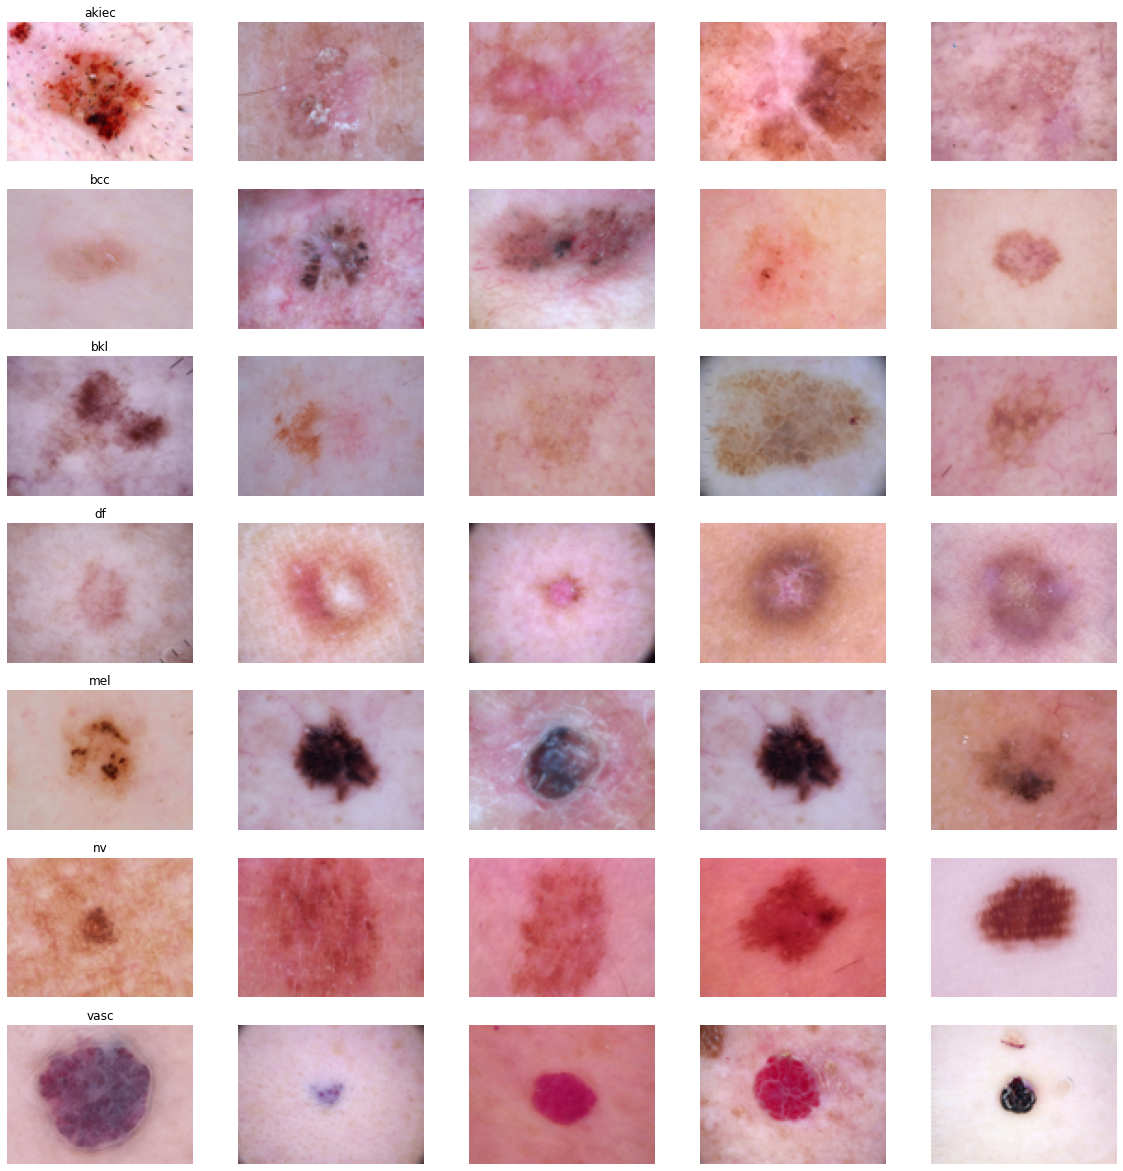

In [22]:
n_samples=5 # number of samples for plotting 

# Plotting

fig, m_axs= plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))

for n_axs ,(type_name,type_rows) in zip(m_axs,skin_df_balanced.sort_values(['dx']).groupby('dx')):

    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')


In [23]:
#Convert dataframe column of images into numpy array
X=np.asarray(skin_df_balanced['image'].tolist())


 # Scale values to 0-1. You can also used standardscaler or other scaling methods.
X=X/255.
Y=skin_df_balanced['label'] 

 #Convert to categorical as this is a multiclass classification problem
Y_cat=to_categorical(Y,num_classes=7)

In [24]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y_cat,test_size=0.25,random_state=42)

 We can use Image Data Generator for data augumentation and to  reduce the over fitting of the model 

In [44]:
#clf = ak.ImageClassifier(max_trials=25) #MaxTrials - max. number of keras models to try
#clf.fit(X_train, Y_train, epochs=25)

<h1  style="color:lime ;font-size:40px" >Making the CNN Model  </h1>

In [29]:
num_classes=7
model=Sequential()
model.add(Conv2D(256,(3,3),activation='relu',input_shape=(75,100,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,activation='softmax'))
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 73, 98, 256)       7168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 36, 49, 256)      0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 36, 49, 256)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 34, 47, 128)       295040    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 17, 23, 128)      0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 17, 23, 128)      

In [30]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [49]:
# CallBacks
''''
from keras.callbacks import EarlyStopping , ModelCheckpoint

# early stopping

es=EarlyStopping(monitor='val_accuracy',min_delta=0.01,patience=4,verbose=1)

# model checkpoint

mc=ModelCheckpoint(filepath="./bestmodel.h5",monitor='val_accuracy',verbose=1,save_best_only=True)

cb=[es,mc]
'''

'\'\nfrom keras.callbacks import EarlyStopping , ModelCheckpoint\n\n# early stopping\n\nes=EarlyStopping(monitor=\'val_accuracy\',min_delta=0.01,patience=4,verbose=1)\n\n# model checkpoint\n\nmc=ModelCheckpoint(filepath="./bestmodel.h5",monitor=\'val_accuracy\',verbose=1,save_best_only=True)\n\ncb=[es,mc]\n'

In [35]:

epochs=50

history=model.fit(X_train,Y_train,epochs=epochs,validation_data=(X_test,Y_test),verbose=2)

Epoch 1/50
83/83 - 74s - loss: 1.5623 - accuracy: 0.3528 - val_loss: 1.5890 - val_accuracy: 0.3371 - 74s/epoch - 891ms/step
Epoch 2/50
83/83 - 93s - loss: 1.5279 - accuracy: 0.3707 - val_loss: 1.5383 - val_accuracy: 0.3909 - 93s/epoch - 1s/step
Epoch 3/50
83/83 - 84s - loss: 1.4559 - accuracy: 0.4023 - val_loss: 1.4065 - val_accuracy: 0.4023 - 84s/epoch - 1s/step
Epoch 4/50
83/83 - 92s - loss: 1.4249 - accuracy: 0.4034 - val_loss: 1.3607 - val_accuracy: 0.4126 - 92s/epoch - 1s/step
Epoch 5/50
83/83 - 88s - loss: 1.3879 - accuracy: 0.4301 - val_loss: 1.4775 - val_accuracy: 0.4000 - 88s/epoch - 1s/step
Epoch 6/50
83/83 - 79s - loss: 1.3797 - accuracy: 0.4434 - val_loss: 1.3006 - val_accuracy: 0.4606 - 79s/epoch - 952ms/step
Epoch 7/50
83/83 - 87s - loss: 1.3541 - accuracy: 0.4484 - val_loss: 1.3804 - val_accuracy: 0.4411 - 87s/epoch - 1s/step
Epoch 8/50
83/83 - 85s - loss: 1.3142 - accuracy: 0.4667 - val_loss: 1.2822 - val_accuracy: 0.4571 - 85s/epoch - 1s/step
Epoch 9/50
83/83 - 89s - l

In [36]:
score=model.evaluate(X_test,Y_test)
print("Test Accuracy ",score[1])

28/28 [==============================] - 5s 193ms/step - loss: 0.8954 - accuracy: 0.7063
Test Accuracy  0.7062857151031494


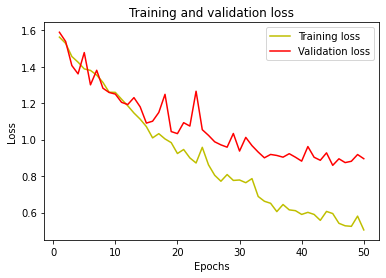

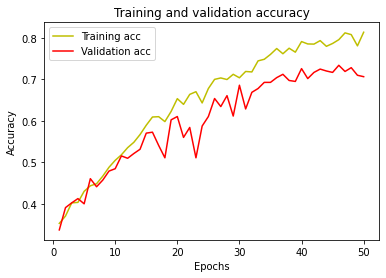

In [39]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [40]:
# Prediction on test data
y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(Y_test, axis = 1) 

28/28 [==============================] - 10s 336ms/step


In [42]:
#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

[[ 95  14  20  13   3   4   0]
 [ 22  71  22   6   4   2   1]
 [  5   6  81   3  17   8   0]
 [  0  10   4 114   0   0   0]
 [  8   4  14   1  69  16   0]
 [  3   3  13   2  26  66   0]
 [  0   1   0   1   0   1 122]]


<AxesSubplot:>

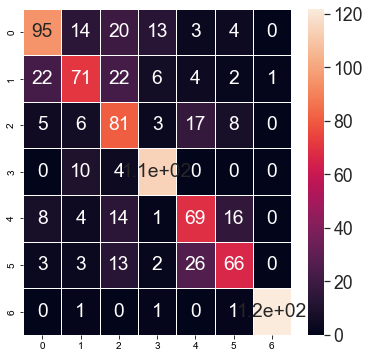

In [43]:
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


<h1  style="color:Yellow ;font-size:40px" > Further we can make Predictive System to predict the Type of Cancer  </h1>